# Weather and Wildfire Activity

### Research Question: Is there a connection between the number of wildfires to the average temperature and precipitiation during that year's summer/winter?

### Hypothesis: In years that there are more wildfires, the average summer temperatures will be hotter and the precipitation in Summer and Winter less due to the fact that fires thrive in hot and dry conditions along with how conditions in Summers can often dictate Winter patterns.

## Datasets and Background

The datasets found for use in this analysis include a few different ones from different places to gather the full picture related to the hypothesis and research question. Finding historical weather data matching up with the dates of the wildfire datasets is quite challenging as many have paywalls or, while being open-source, some datasets only allow for a certain amount of data requests at a time. Thankfully NOAA is very generous with providing their global and significant data collection to the public for free.


The first dataset I will be using is provided by the National Oceanic and Atmospheric Administration (NOAA) (https://www.ncdc.noaa.gov/cdo-web/search), who have an extensive weather dataset from weather stations all around the globe. This data I requested from NOAA (Global Summary of the Month Dataset (GSOM) - [Documentation for GSOM and GSOY here](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/gsom-gsoy_documentation.pdf)) goes from January 1974 to October 2020 and includes all of the analytics from two weather stations in that time. Due to request limitations, its impossible to request every single weather station in Boulder (there are many), so I chose two weather stations that have historical data dating back to the start date I needed AND continue up until today. Many weather stations were either installed after the date or were decomissioned at points. To get a reliable and consistent dataset, using weather from date A to B is important rather than relying on other sensors in different locations. The two weather stations I selected were from Boulder, CO US and Gross Reservoir, CO US. These were some of the first weather stations placed in Boulder County that are still functional today. Additionally, they are also placed in somewhat different climate conditions. Gross Reservoir is at a higher elevation, in the mountains/foothills, and near densely wooded areas whereas the Boulder station is located at the base of the foothills, at a lower elevation, and in the city (with homes and businesses, not dense forest).

The second and third datasets are provided by Boulder County (https://opendata-bouldercounty.hub.arcgis.com/search). One is a historical record of wildfires in the county containing the name, (sometimes) start date, end date, and the size/shape of the fire. Unfortunately, this dataset only includes wildfire data up until April 2017; more on this in the following paragraph. The other dataset from Boulder County is a CSV and shapefile of the location, name, address, city, district, etc. regarding fire stations dotted across the county. This will provide the ability to add fire station locations and give context to the question at hand. It appears that this file used to have the number of volunteers and paid firefighters working at each station but it looks like this may only be an internal metric that is not provided to the public. If I had access to this, it would be interesting to see how different fire stations are staffed depending on the proximity to the majority of wildfires in the county.

Finally, the last dataset I will be utilizing is the NASA VIIRS sattelite readings (https://firms2.modaps.eosdis.nasa.gov/download/). This satellite can look for areas with high temperatures (hotspots) across the globe which can give indication to where a wildfire might be. I manually selected the region using the following polygon below which is roughly the area of Boulder County. 

POLYGON((-105.67623 39.93125,-105.67349 40.01639,-105.63984 40.03493,-105.63023 40.1393,-105.66525 40.17089,-105.65014 40.25809,-105.05413 40.26221,-105.05001 39.99991,-105.05413 39.97657,-105.12692 39.95459,-105.14614 39.91408,-105.39677 39.91339,-105.4002 39.93331,-105.67623 39.93125))

These satellites are not 100% accurate but it will give some insight into dates and sizes of fires from 2017 up until very recently (as the Boulder county data only goes up until 2017). 

## Load in Datasets

All of the libraries below will be utilized in this notebook.

In [1]:
# libraries for use in the notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import geopandas as gpd
import geoplot, contextily
import geoplot.crs as gcrs
import contextily
import pyproj
from pyproj import CRS

In [2]:
# weather stations data csv
monthly_weather = pd.read_csv('noaa_global_summary_of_the_month.csv')

In [3]:
# boulder county wildfire historical data up until April 2017
wildfire_history_csv = pd.read_csv('Wildfire_History.csv')
wildfire_history_gdf = gpd.read_file('Wildfire_History-shp/Wildfire_History.shp')

In [4]:
# fire stations csv and gdf
fire_stations_csv = pd.read_csv('Fire_Stations.csv')
fire_stations_gdf = gpd.read_file('Fire_Stations-shp/Fire_Stations.shp')

In [5]:
# VIIRS satellite csv files (archive is from April 2017 to the end of May 2020) 
viirs_archive_csv = pd.read_csv('DL_FIRE_V1_CSV/fire_archive_V1_10112.csv')
viirs_new_csv = pd.read_csv('DL_FIRE_V1_CSV/fire_nrt_V1_10112.csv')
# VIIRS satellite shape files (archive is from April 2017 to the end of May 2020) 
viirs_archive_gdf = gpd.read_file('DL_FIRE_V1_ShapeFiles/fire_archive_V1_10113.shp')
viirs_new_gdf = gpd.read_file('DL_FIRE_V1_ShapeFiles/fire_nrt_V1_10113.shp')

In [6]:
# A look into the VIIRS satellite data. Note the important columns that will be utilized such as 
# the acq_date and location (lat/long)
viirs_new_csv.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight
0,40.20193,-105.23838,297.1,0.39,0.36,2020-09-03,854,N,VIIRS,n,2.0NRT,285.4,0.6,N
1,40.20135,-105.23892,296.9,0.40,0.45,2020-09-07,918,N,VIIRS,n,2.0NRT,285.6,0.5,N
2,40.20167,-105.23685,296.9,0.42,0.61,2020-09-27,948,N,VIIRS,n,2.0NRT,281.8,0.8,N
3,40.20229,-105.23642,296.7,0.39,0.36,2020-09-30,848,N,VIIRS,n,2.0NRT,284.0,0.7,N
4,40.20125,-105.23721,297.1,0.35,0.57,2020-10-08,942,N,VIIRS,n,2.0NRT,280.6,0.6,N


## Background Context

#### Plot Boulder County's Wildfires

Let's look at where these fires have mostly occurred throughout the years to give us some context about the problem. The black dots superimposed indicate a fire station. 

We can see that there are some groupings of where most of the fires have happened. The place where the green shaded area meets the white/tan area is the line where elevation climbs dramatically (going into the foothills/mountains). Based on background knowledge of the area, these groupings of fires took place in heavily wooded areas that also have higher populations and more human traffic. 

While looking at the fire locations and perimeters, it is interesting to look at how the groupings of fires are close to fire stations (and the fact that there are more fire stations clustered in the foothills than in the city of Boulder itself).

*Note that these wildfires all took place between the years of 1974 and 2017.*

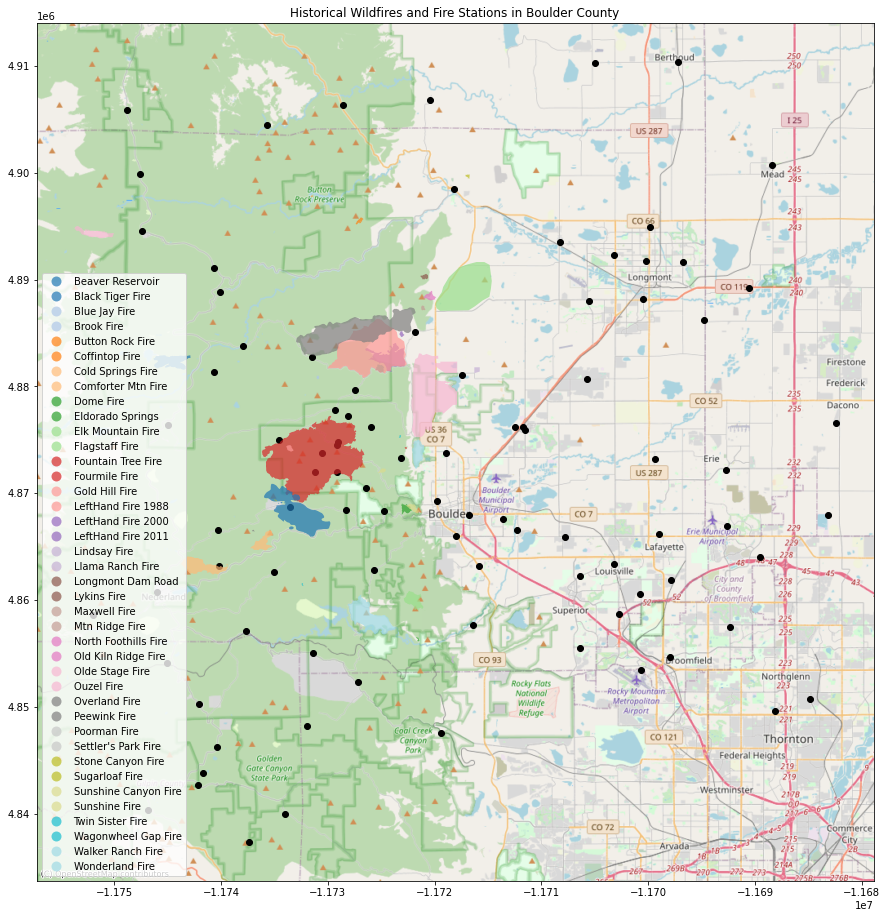

In [7]:
# converting these geodataframes to contain a CRS is critical to mapping it with something like a basemap
fire_stations_3857_gdf = fire_stations_gdf.to_crs('EPSG:3857')
wildfire_history_3857_gdf = wildfire_history_gdf.to_crs('EPSG:3857')

f,ax = plt.subplots(figsize=(15,30))

fire_stations_3857_gdf.plot(ax=ax,color='black')
wildfire_history_3857_gdf.plot(ax=ax,column='LABELNAME',legend=True,alpha=.7,cmap='tab20')

contextily.add_basemap(ax,source=contextily.providers.OpenStreetMap.Mapnik)

ax.set_title("Historical Wildfires and Fire Stations in Boulder County")
plt.show()

## Clean and Organize Datasets

### Create Seasonal Datasets

We are going to filter the monthly weather dataset by meteorological season. This will be beneficial and make sense for 2 main reasons. First, this is weather data that only includes weather averages by month instead of by day therefore dealing with the soltice and equinox is challenging because these days occur in the middle of the month (ex. it could be 80 degrees at the beginning of the month and 50 toward the end). Meteorological seasons also make more sense than astronomical seasons due to how temperature trends occur in Boulder (for example, it gets colder much earlier than the Winter solstice). 

Using some simple regex, we can specify which months we want.

In [8]:
# Seasons: 
# Spring=March to May
sp_monthly_weather = monthly_weather[monthly_weather['DATE'].str.contains('-03|-04|-05')==True]
# Summer=June to August
su_monthly_weather = monthly_weather[monthly_weather['DATE'].str.contains('-06|-07|-08')==True]
# Fall=September to November
fa_monthly_weather = monthly_weather[monthly_weather['DATE'].str.contains('-09|-10|-11')==True]
# Winter=December to February
wi_monthly_weather = monthly_weather[monthly_weather['DATE'].str.contains('-12|-01|-02')==True]

## Summer Weather Analysis

Summers are when most fires occur so we will first look at how weather patterns in this season relate to wildfire activity over time.

In [9]:
# separate boulder and gross reservoir weather stations as they are in very different areas of the county
boulder_su_monthly_weather = su_monthly_weather.loc[su_monthly_weather['NAME'] == 'BOULDER, CO US']
gross_su_monthly_weather = su_monthly_weather.loc[su_monthly_weather['NAME'] == 'GROSS RESERVOIR, CO US']

# the different weather patterns of the weather stations is made clear by difference in elevation
print("Boulder Elevation Avg Elevation")
print(boulder_su_monthly_weather['ELEVATION'].mean())
print("\nGross Reservoir Avg Elevation")
print(gross_su_monthly_weather['ELEVATION'].mean())

Boulder Elevation Avg Elevation
1671.5

Gross Reservoir Avg Elevation
2429.2999999999943


In [10]:
# just a quick look into what the NOAA dataset contains 
# (the abbreviated codes such as `CDSD` are explained in the documentation)
boulder_su_monthly_weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,CDSD,CDSD_ATTRIBUTES,CLDD,CLDD_ATTRIBUTES,...,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
5,USC00050848,"BOULDER, CO US",39.9919,-105.2667,1671.5,1974-06,187.0,0,157.0,",0",...,2.08,",,,0",0.0,",,,0",68.0,",0",83.5,",,,0",52.5,",,,0"
6,USC00050848,"BOULDER, CO US",39.9919,-105.2667,1671.5,1974-07,443.0,0,256.0,",0",...,0.53,",,,0",0.0,",,,0",73.3,",0",88.4,",,,0",58.1,",,,0"
7,USC00050848,"BOULDER, CO US",39.9919,-105.2667,1671.5,1974-08,571.0,0,128.0,",0",...,0.38,",,,0",0.0,",,,0",68.6,",0",83.4,",,,0",53.9,",,,0"
17,USC00050848,"BOULDER, CO US",39.9919,-105.2667,1671.5,1975-06,78.0,0,70.0,",0",...,2.01,",,,0",0.0,",,,0",64.2,",0",78.7,",,,0",49.7,",,,0"
18,USC00050848,"BOULDER, CO US",39.9919,-105.2667,1671.5,1975-07,300.0,0,221.0,",0",...,1.68,",,,0",0.0,",,,0",72.1,",0",87.1,",,,0",57.1,",,,0"


In [11]:
# convert the date column to datetime timestamps
boulder_su_monthly_weather['DATE'] = pd.to_datetime(boulder_su_monthly_weather['DATE'])
gross_su_monthly_weather['DATE'] = pd.to_datetime(gross_su_monthly_weather['DATE'])
# confirm in datetime format
print(boulder_su_monthly_weather['DATE'].dtypes)
print(gross_su_monthly_weather['DATE'].dtypes)

# the warnings that pop up here are not detrimental to the code at this time
# the code will need to be revised at some point in the future once they patch this method and it becomes an error

datetime64[ns]
datetime64[ns]


<ipython-input-11-ec40d26b18c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boulder_su_monthly_weather['DATE'] = pd.to_datetime(boulder_su_monthly_weather['DATE'])
<ipython-input-11-ec40d26b18c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross_su_monthly_weather['DATE'] = pd.to_datetime(gross_su_monthly_weather['DATE'])


### Look at Historical Summer Temperature Patterns

How has the temperature changed in the last 40 years? There is a slight rising trend going on here.

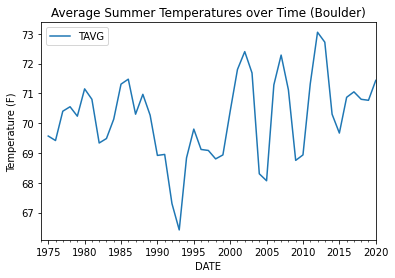

In [12]:
boulder_su_weather = boulder_su_monthly_weather.groupby(pd.Grouper(key='DATE',freq='1y')).agg({'TAVG':'mean'})
ax = boulder_su_weather.rolling(2).mean().plot()
ax.set_ylabel('Temperature (F)')
ax.set_title('Average Summer Temperatures over Time (Boulder)')
plt.show()

Looking at the avg temperature of the gross reservoir weather station, the station stopped recording data for about 20 years related to average temperature but continued it in the early 2000s. Regardless, having the steady boulder data will show trends within Boulder County (the weather in the city wont be too drastically different than up in the mountains, especially in regards to weather patterns). 

We can use this to supplement the boulder weather data starting around 2005

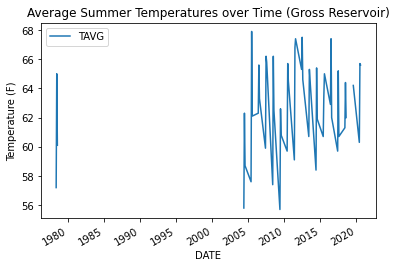

In [13]:
ax = gross_su_monthly_weather.plot(x='DATE',y='TAVG',kind='line')
ax.set_ylabel('Temperature (F)')
ax.set_title('Average Summer Temperatures over Time (Gross Reservoir)')
plt.show()

### Look at Historical Summer Precipitation Patterns

How has the precipitation in the summer changed over the last 40 years? Now this is also interesting, we had a rising trend of precipitation amounts during the summer but since about 2007, this has tapered off dramatically. 

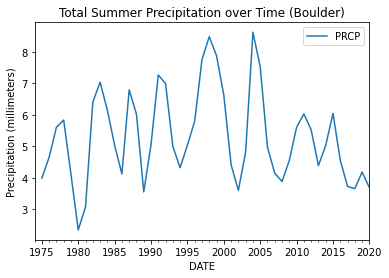

In [14]:
boulder_su_precip = boulder_su_monthly_weather.groupby(pd.Grouper(key='DATE',freq='1y')).agg({'PRCP':'sum'})
ax = boulder_su_precip.rolling(2).mean().plot()
ax.set_ylabel('Precipitation (millimeters)')
ax.set_title('Total Summer Precipitation over Time (Boulder)')
plt.show()

The Gross Reservoir data indicates the same thing as the Boulder station, but even more dramatically. Notice how in the past 15 years, total summer precipitation dropped off significantly with a low of just 2mm in 2019!

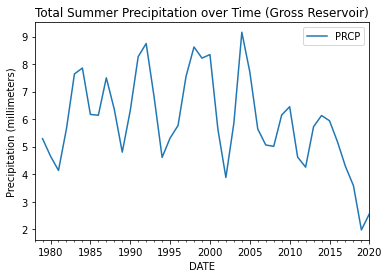

In [15]:
gross_su_precip = gross_su_monthly_weather.groupby(pd.Grouper(key='DATE',freq='1y')).agg({'PRCP':'sum'})
ax = gross_su_precip.rolling(2).mean().plot()
ax.set_ylabel('Precipitation (millimeters)')
ax.set_title('Total Summer Precipitation over Time (Gross Reservoir)')
plt.show()

### Bring on the Heat (Summer)

How do Boulder's summer weather patterns relate to fire activity over the years?

#### Let's compare Boulder's Wildfire History with its Historical (Summer) Temperatures

We can count how many fires occurred every year and plot this out to determine how temperature coorelates to fire activity.

In [16]:
# convert the wildfire history dates to timestamps
wildfire_history_csv['STARTDATE'] = pd.to_datetime(wildfire_history_csv['STARTDATE'])
wildfire_history_csv['ENDDATE'] = pd.to_datetime(wildfire_history_csv['ENDDATE'])

In [17]:
# lets only keep the years though to give us a more easily plottable dataset
# we're going to apply this to the wildfires dataset while also counting up the number of fires in that year
wildfires_yearly = wildfire_history_csv['ENDDATE'].dt.year.value_counts(sort=False)
wildfires_yearly.sort_index(axis=0, ascending=True, inplace=True)
# we are also going to apply this to the boulder_su_weather (temp) data to give us just the year
boulder_su_weather.index = boulder_su_weather.index.year

Looking at the chart below. Its clear that there is some sort of coorelation between lower temperatures and less fire activity and higher temperatures and more fire activity. For example, around the year 2000, the average summer temperature was one of the hottest in the history of this weather station. We can also see several points (around 2004), where the average temperature dropped to around 67 and there were 0 fires that year. 

Once we hit 2017, you will notice that the temperature data continues but the fire activity remains at 0. This could either be because there were actually no fires in the years up until today, or, the more likely explanation is the fact that the Boulder County fire data only reaches about 2016/2017. 

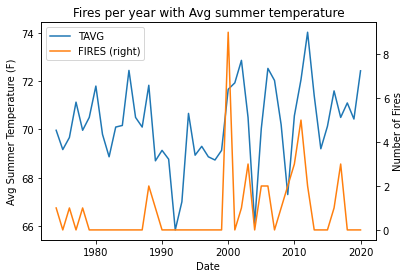

In [18]:
boulder_fires_su_weather = boulder_su_weather.merge(wildfires_yearly, 
                                                    how='outer', 
                                                    left_index=True, 
                                                    right_index=True).fillna(0)

boulder_fires_su_weather = boulder_fires_su_weather.rename(columns = {'ENDDATE':'FIRES'})

ax = boulder_fires_su_weather.plot(secondary_y='FIRES')
ax.right_ax.set_ylabel('Number of Fires')
ax.set_ylabel('Avg Summer Temperature (F)')
ax.set_title('Fires per year with Avg summer temperature')
ax.set_xlabel('Date')
plt.show()

In [19]:
# This indicates that there is some sort of positive correlation between the the average summer temperatures and 
# fires per year
boulder_fires_su_weather.corr(method='spearman')

,TAVG,FIRES
TAVG,1.000000,0.302762
FIRES,0.302762,1.000000


In this autocorrelation plot, it indicates that there are both positive and negative correlations meaning that when its positive, this is likely attributed to higher temps = more fire and when the correlation is negative, it likely means lower temps = less fire. 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

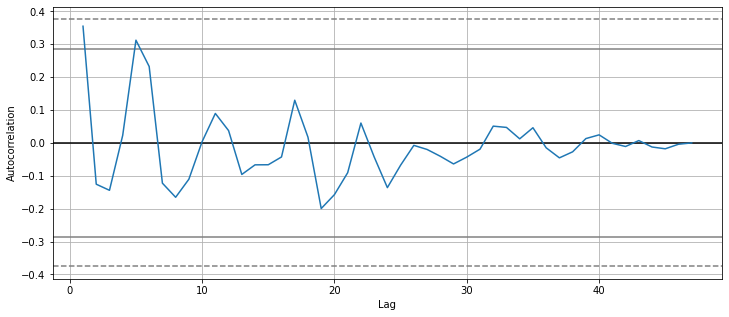

In [20]:
f,ax = plt.subplots(figsize=(12,5))
pd.plotting.autocorrelation_plot(boulder_fires_su_weather['TAVG'],ax=ax)

#### Now let's look at if the precipitation follows similar trends

Just as above, we can count how many fires occurred every year and plot this out along with the precipitation to check for any connections.

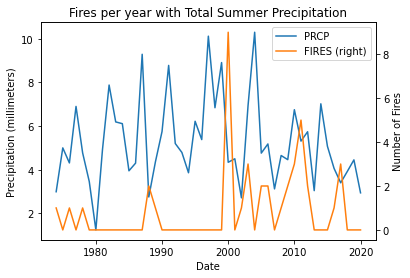

In [21]:
# since we have already counted up the number of fires per year, we don't need to repeat this step

# we are going to apply the same concepts that were used above to the precip data
boulder_su_precip.index = boulder_su_precip.index.year
boulder_su_precip.head()

# and just as above, lets merge the fires and precip datasets together and plot it
boulder_fires_su_precip = boulder_su_precip.merge(wildfires_yearly, 
                                                    how='outer', 
                                                    left_index=True, 
                                                    right_index=True).fillna(0)

boulder_fires_su_precip = boulder_fires_su_precip.rename(columns = {'ENDDATE':'FIRES'})

ax = boulder_fires_su_precip.plot(secondary_y='FIRES')
ax.right_ax.set_ylabel('Number of Fires')
ax.set_ylabel('Precipitation (millimeters)')
ax.set_title('Fires per year with Total Summer Precipitation')
ax.set_xlabel('Date')
plt.show()

What are we learning in these next two cells? It appears that, opposite to the way that temperature affected fires positively (increased temp --> more fires), precipitation affects it negatively (less precip --> more fires). 

Having just the correlation between the temp and fire activity is one thing, now however, we have a correlation between the precipitation and fire activity as well.

In [22]:
# This indicates that there is some sort of negative correlation between the the precipitation and 
# fires per year
boulder_fires_su_precip.corr(method='spearman')

,PRCP,FIRES
PRCP,1.0000,-0.1918
FIRES,-0.1918,1.0000


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

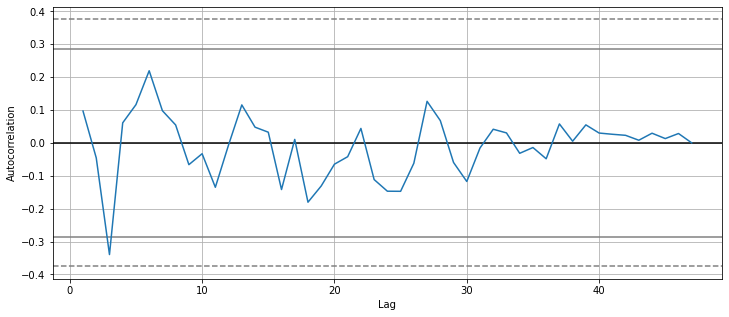

In [23]:
f,ax = plt.subplots(figsize=(12,5))
pd.plotting.autocorrelation_plot(boulder_fires_su_precip['PRCP'],ax=ax)

## Winter Weather Analysis

We took a look at connections between fire activity and summer temperatures/precipitation, now lets look at the winter.

Can fire activity of a certain year be an indication as to the average winter precipitation? Lets find out.

In [24]:
# separate boulder and gross reservoir weather stations as they are in very different areas of the county
boulder_wi_monthly_weather = wi_monthly_weather.loc[wi_monthly_weather['NAME'] == 'BOULDER, CO US']
gross_wi_monthly_weather = wi_monthly_weather.loc[wi_monthly_weather['NAME'] == 'GROSS RESERVOIR, CO US'] 

# convert the date column to datetime timestamps
boulder_wi_monthly_weather['DATE'] = pd.to_datetime(boulder_wi_monthly_weather['DATE'])
gross_wi_monthly_weather['DATE'] = pd.to_datetime(gross_wi_monthly_weather['DATE'])

# confirm in datetime format
print(boulder_su_monthly_weather['DATE'].dtypes)
print(gross_su_monthly_weather['DATE'].dtypes)

datetime64[ns]
datetime64[ns]


<ipython-input-24-d01789bf116a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boulder_wi_monthly_weather['DATE'] = pd.to_datetime(boulder_wi_monthly_weather['DATE'])
<ipython-input-24-d01789bf116a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross_wi_monthly_weather['DATE'] = pd.to_datetime(gross_wi_monthly_weather['DATE'])


Based off of this chart below, its hard to say whether or not snowfall has been increasing or decreasing over time. There was a range of about 10 years with regularly higher snowfall amounts but nothing significant enough to be conclusive.

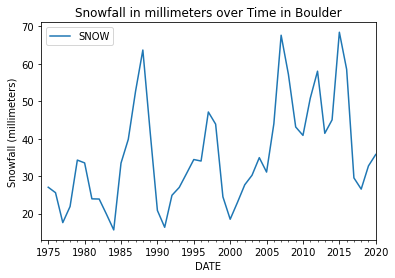

In [25]:
boulder_wi_snow = boulder_wi_monthly_weather.groupby(pd.Grouper(key='DATE',freq='1y')).agg({'SNOW':'sum'})
ax = boulder_wi_snow.rolling(2).mean().plot()
ax.set_ylabel('Snowfall (millimeters)')
ax.set_title('Snowfall in millimeters over Time in Boulder')
plt.show()

Just to cover our bases, let's look at Gross Reservoir's data as well, see if it followed similar patterns to Boulder.

It looks quite similar with even the snowfall amounts being relatively the same (usually for the foothills higher amounts are expected).

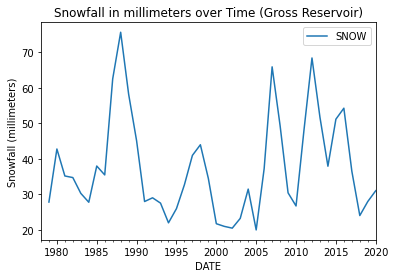

In [26]:
gross_wi_snow = gross_wi_monthly_weather.groupby(pd.Grouper(key='DATE',freq='1y')).agg({'SNOW':'sum'})
ax = gross_wi_snow.rolling(2).mean().plot()
ax.set_ylabel('Snowfall (millimeters)')
ax.set_title('Snowfall in millimeters over Time (Gross Reservoir)')
plt.show()

### Bring on the Heat (Winter)

How does fire activity in Boulder county relate to winter snowfall over the years?

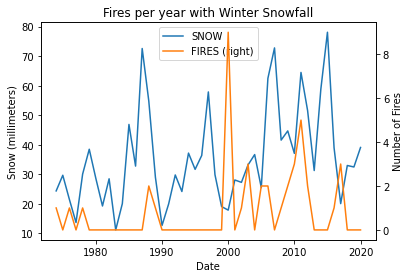

In [27]:
# since we have already counted up the number of fires per year, we don't need to repeat this step

# again, same as before, following the same steps to reindex and only keep the years
boulder_wi_snow.index = boulder_wi_snow.index.year

# and just as above, lets merge the fires and precip datasets together and plot it
boulder_fires_wi_snow = boulder_wi_snow.merge(wildfires_yearly, 
                                                    how='outer', 
                                                    left_index=True, 
                                                    right_index=True).fillna(0)

boulder_fires_wi_snow = boulder_fires_wi_snow.rename(columns = {'ENDDATE':'FIRES'})

ax = boulder_fires_wi_snow.plot(secondary_y='FIRES')
ax.right_ax.set_ylabel('Number of Fires')
ax.set_ylabel('Snow (millimeters)')
ax.set_title('Fires per year with Winter Snowfall')
ax.set_xlabel('Date')
plt.show()

In [28]:
# This indicates that there is some sort of slight positive correlation between the the precipitation and 
# fires per year
boulder_fires_wi_snow.corr(method='spearman')

,SNOW,FIRES
SNOW,1.000000,0.096914
FIRES,0.096914,1.000000


Based on the correlation above and below, and by looking at the chart comparing fires and snowfall, it's become clear that the claim of predicting the winter will be drier after a bad fire season is mostly unfounded. There are some years where there were several fires and the winter was drier (such as 2000) but looking at precipitation and temperature over the summer from earlier in the analysis, those just tended to be drier years in general. The logic just cannot be applied to every single year. For example, if we take a look at around 2011, there were 5 fires that year as well as a healthy amount of snowfall. The only other timeframe an argument could be made about is between 2000 and 2007. There was a streak of almost 1+ fires per year and the snowfall was quite low. 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

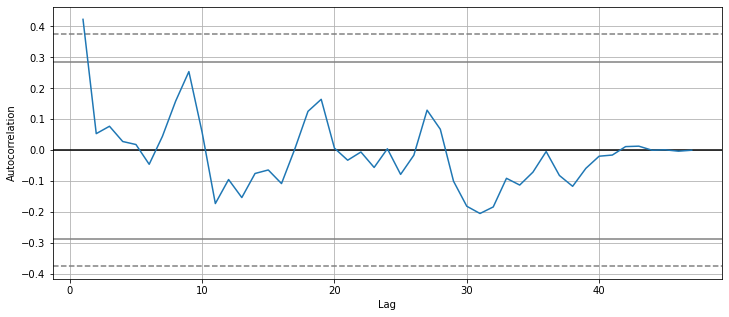

In [29]:
f,ax = plt.subplots(figsize=(12,5))
pd.plotting.autocorrelation_plot(boulder_fires_wi_snow['SNOW'],ax=ax)

## What about these last few years? The other dataset didn't include information about fires related to recent years.

This is where the VIIRS satellite hotspots come into play. NASA provides open source data from this satellite that shows hotspots across the globe. As mentioned in the beginning, these play a major role in detecting wildfires. Unfortunately, they also detect random hotspots that occur either naturally or due to human intervention. For example, if you look at this data in Texas or Alaska, many of the hotspots are directly in oilfields where its common for a flame to omit from the top of a drill. 

The below map shows hotspots that were detected between 2017 and early 2020. The data is archived after a certain amount of time which is why we have two different datasets for the satellite. 

Googling around for fires in the area during this time frame led to little to no indication of wildfires or even house fires for that matter. Many of these hotspots show up in the same areas and also take place during the middle of winter or late fall. Its possible that these are some type of industrial buildings that let off a lot of heat in the winter or controlled burning fires that the satellite happened to pick up. This leads me to believe that during this time frame (late 2017 to early 2020), little to no wildfires occured in Boulder County.

While it was still important to investigate what the fire activity was, these few years do not need to be manually added to the above analyses, particularly with how little fire activity they contained.

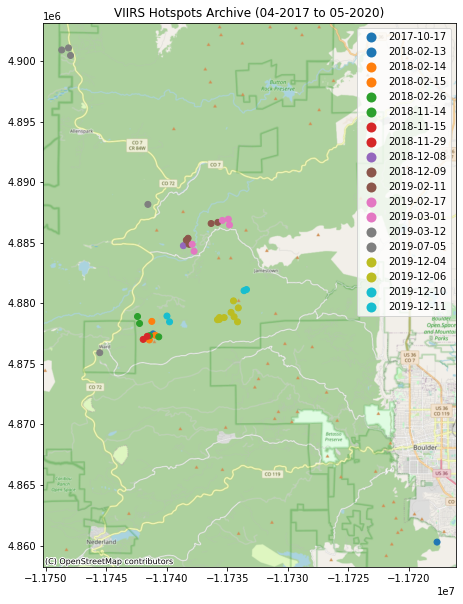

In [30]:
viirs_archive_3857_gdf = viirs_archive_gdf.to_crs('EPSG:3857')
viirs_archive_3857_gdf_update = viirs_archive_3857_gdf.loc[viirs_archive_3857_gdf['LONGITUDE']<= -105.260]
f,ax = plt.subplots(figsize=(10,10))

viirs_archive_3857_gdf_update.plot(column='ACQ_DATE',ax=ax,legend=True)

contextily.add_basemap(ax,source=contextily.providers.OpenStreetMap.Mapnik)

ax.set_title("VIIRS Hotspots Archive (04-2017 to 05-2020)")

plt.show()

## What about 2020?

2020 was quite a year, in not a very positive way. Boulder County and wildfires were no exception; in the later months of 2020, Boulder County was hit with the largest and most destructive wildfire in its history. Not only that, but it came at a time when resources were already stretched extremely thin due to other historic fires across the state. 

The VIIRS satellite imagery, while not super important to add to the above analysis, does show how significant this fire season was and can contribute to the argument of hotter summers/warming trends year over year is contributing to excessive wildfire activity. For example, below I have included the historical temperature chart that we looked at earlier.

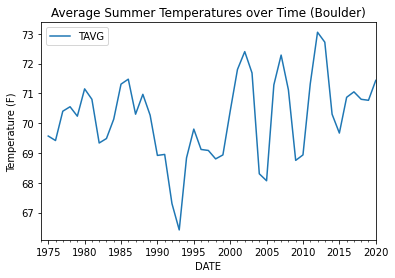

In [31]:
boulder_su_weather = boulder_su_monthly_weather.groupby(pd.Grouper(key='DATE',freq='1y')).agg({'TAVG':'mean'})
ax = boulder_su_weather.rolling(2).mean().plot()
ax.set_ylabel('Temperature (F)')
ax.set_title('Average Summer Temperatures over Time (Boulder)')
plt.show()

2020 followed the warming trend that has been happening over the years and it just happened to really catch up with Colorado this year. In the map below these two fires are shown. In the bottom left of the map, the [2020 Lefthand Canyon fire](https://inciweb.nwcg.gov/incident/7247/) began and grew just a day after the [Calwood Fire](https://inciweb.nwcg.gov/incident/7245/). As of writing today, the Lefthand Canyon fire is 100% contained at 460 acres. The Calwood Fire went on to burn [10,106 acres](https://www.9news.com/article/news/local/wildfire/calwood-fire-boulder-county-100-contained/73-7c910989-5a95-428d-b16c-bb11b71ac10e) and destroy [at least 26 homes](https://www.cnn.com/2020/10/19/us/colorado-utah-wildfires-calwood/index.html) and can be seen in the top-center of the map. Using the legend, progression of the flames can be seen day to day.

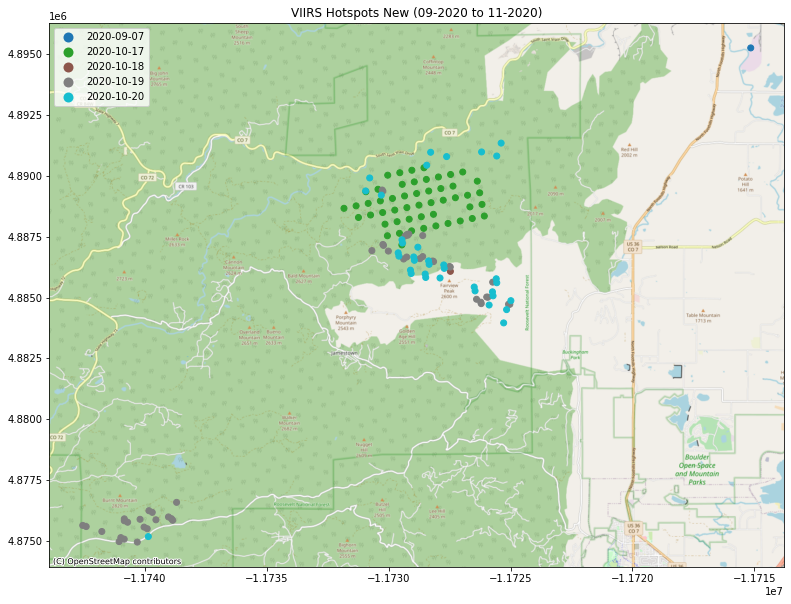

In [32]:
viirs_new_3857_gdf = viirs_new_gdf.to_crs('EPSG:3857')
viirs_new_3857_gdf_update = viirs_new_3857_gdf.loc[viirs_new_3857_gdf['LONGITUDE']<= -105.2385]
f,ax = plt.subplots(figsize=(15,10))

viirs_new_3857_gdf_update.plot(column='ACQ_DATE',ax=ax,legend=True)

contextily.add_basemap(ax,source=contextily.providers.OpenStreetMap.Mapnik)

ax.set_title("VIIRS Hotspots New (09-2020 to 11-2020)")

plt.show()

## Conclusion

The hypothesis of "In years that there are more wildfires, the average summer temperatures will be hotter and the precipitation in Summer and Winter less due to the fact that fires thrive in hot and dry conditions along with how conditions in Summers can often dictate Winter patterns." was supported and denied in a few different ways. 

The analysis revealed these key takeaways: 

1. There is a correlation between wildfire activity and average summer temperatures. Summer temperatures are also rising over time.
    - Wildfires thrive in hot and dry conditions, this makes fuel such as timber, dry brush, and bushes easy for the fire to burn, and burn quickly. This doesn't come as too much of a surprise but is interesting to see how bad 'wildfire seasons' occur and seem to contribute to subsequent years of dry weather. The second part of this takeaway is the indisputable fact that the average summer temperature has risen according to the data since the 1970s. Wildfires have also not only gotten more frequent but larger as well. 2020 is a prime example of this. The most destructive and largest fires occurred not just in Boulder County's history, but the state's history. 
    

2. A lack of precipitation can be connected to higher wildfire activity than years with wetter seasons.
    - This takeaway doesn't come as much of a surprise either. Wetter seasons make it harder for wildfires to start, period. If lightning strikes a tree while its raining or been raining recently, the likelihood is, nature will extinguish it before it becomes too large; or in the case that it does spread, wet conditions will support firefighting efforts to put it out. The same goes for if a fire is man made, wet conditions are simply more likely to prevent the spread of a fire caused by a cigarrette being thrown out the window of a car. 
    

3. Wildfire activity is not directly correlated to winter snowfall amounts.
    - The analysis showed that there is a slight connection to winter snowfall amounts and wildfire activity but not strong enough to make a statement in agreement with it. The biggest thing that the snowfall analysis revealed was how winter dry spells could contribute to worse wildfire seasons. As mentioned before, the time frame of 2000 to around 2007 indicated one of these dry winter, high wildfire activity timeframes. Although this wasn't part of the original hypothesis, dry winters may be able to help predict dry summers (or at least if there are a couple dry winters in a row). What would be interesting to look at is when these wildfires occurred in the year. Between 2000 and 2005, its quite possible that wildfires happened earlier in the year (around maybe April, May, June) versus later in the year when temperatures are typically hotter. If this were true, it would be safe to say that extremely dry winters lead to a rapid decrease in snowmelt (particularly in the high country) and fuel dries out faster. These factors put together could lead to an early wildfire season and an even bigger possibility for massive fires later (around August when temps are even hotter). 


4. *2020 was a bad year for fires.*

In the ways that the hypothesis was denied, new findings were revealed which raise new questions. Some further things that would be important to look at are:

- More weather statistics (utilize wind data or even low temperature data)
- The actual sizes of fires over time instead of simply the number per year
- Speed of fire spread
- A look into the usecase of satellite imagery in detecting fires early (see if anyone is doing so already)

These 3 factors all contribute to a further understanding of how wildfire activity is changing. Simply looking at Boulder County's past is bound to reveal insights into patterns across the country and world. 

Some limitations that came up:

- A lack of time to look at other key factors that could contribute to wildfire changes. 
- Not enough resources to gather information from all across Boulder County (there are many more weather stations across the county, getting ideas of weather/climate data from stations close to past fires could reveal new things).
- Privacy limitations: Boulder County has hidden some data (for example with the fire stations dataset) to likely protect privacy. A well intentioned use of this data could possibly help give insight to the county as to how to staff fire stations, respond to wildfires (or use advanced technology like the VIIRS satellite to detect fires early), and mitigate how fires will affect areas should one occur.